In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [163]:
df = pd.read_csv("retouren.csv")

# Data Cleaning

In [164]:
df["user_dob"] = pd.to_datetime(df.user_dob)
df["user_reg_date"] = pd.to_datetime(df.user_reg_date)
df["order_date"] = pd.to_datetime(df.order_date)
df["delivery_date"] = pd.to_datetime(df.delivery_date)

df["age"] = df.order_date.dt.year - df.user_dob.dt.year -((df.order_date.dt.date)<(df.user_dob.dt.date))
df = df.drop(df[df.item_price == 999].index)
df = df.drop(df[df.delivery_date < df.order_date].index)

df.loc[df.item_color == "brwon","item_color"] = "brown"
df.loc[df.item_color == "blau","item_color"] = "blue"
df.loc[df.item_color == "dark oliv","item_color"] = "dark olive"

df = df.drop(df[df.item_color == "?"].index)

df["acc_age"] = df.order_date - df.user_reg_date 
df["acc_age"] = df.acc_age.dt.days

df_mark = df.groupby(["item_id","item_size","item_color"]).agg(maxprice=("item_price","max")).reset_index()
df = pd.merge(df,df_mark)
df["markdown"] = 0
df.loc[df.item_price < df.maxprice,"markdown"] = 1
df.drop(df[df.delivery_date.isna()].index, inplace=True)

In [66]:
df1 = df.copy()

In [67]:
df1.sort_values('order_date', inplace=True)

# Generate order ID and order size
order_id_generator = df1.groupby(['order_date', 'user_id'], sort= False).size().reset_index(name='order_size')
order_id_generator['order_id'] = order_id_generator.index
df1 = pd.merge(df,order_id_generator,on=['user_id', 'order_date'], how='left')

**Item Order Count**

In [103]:
df_order = df1.groupby(["order_id", "item_id"]).agg(color= ("item_color", "unique"), size= ("item_size", "unique"), color_count= ("item_color", "count"), size_count= ("item_size", "count"), returned= ("return", "mean")).reset_index()

In [104]:
df_order

,order_id,item_id,color,size,color_count,size_count,returned
0,0,643,[navy],[38],1,1,0.00
1,1,100,"[red, petrol]","[38, 39]",4,4,0.75
2,1,106,"[blue, berry, white]",[38],5,5,0.80
3,1,155,[berry],[m],1,1,1.00
4,1,157,[purple],[unsized],2,2,0.50
...,...,...,...,...,...,...,...
54538,19378,1445,[red],[xxl],1,1,1.00
54539,19379,1951,[silver],[unsized],1,1,0.00
54540,19380,1470,[red],[l],1,1,0.00
54541,19381,389,[stained],[m],1,1,0.00


**Order_id_generator**

In [165]:
order_id_generator = df.groupby(['order_date', 'user_id'], sort= False).size().reset_index(name='order_size')
order_id_generator['order_id'] = order_id_generator.index
df = pd.merge(df,order_id_generator,on=['user_id', 'order_date'], how='left')

**Order_id**

In [166]:
df_order = df.groupby(["order_id", "item_id"]).agg(color= ("item_color", "unique"), size= ("item_size", "unique"), color_count= ("item_color", "count"), size_count= ("item_size", "count"), returned= ("return", "mean")).reset_index()
df_order1 = df_order[(df_order.color_count >1) | (df_order.size_count >1)]
#df_order1.drop(df_order1.loc[df_order1.returned == 0].index, inplace= True)
df_order1.drop(["color","size","color_count","size_count"], axis=1,inplace=True)
df = pd.merge(df,df_order1,on=["order_id","item_id"],how="left")

/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_72632/2376606678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order1.drop(["color","size","color_count","size_count"], axis=1,inplace=True)


**Age_bins**

In [167]:
df.loc[df.age > 100, "age"] = df.loc[df.age > 100, "age"] - 100
bins=[0,10,20,30,40,50,60,70,80,90,100]
df["age"] = pd.cut(df.age,bins=bins)

**Return Ratio**

In [168]:
df_return_ratio = df.groupby("item_id").agg(returned = ("return", "sum"), item_order= ("return", "count")).reset_index()

In [169]:
df_return_ratio["not_returned"] = df_return_ratio.item_order - df_return_ratio.returned
df_return_ratio["return_ratio"] = df_return_ratio.returned / df_return_ratio.item_order

In [170]:
df_return_ratio.drop(["returned","item_order","not_returned"],axis=1,inplace=True)

In [171]:
df = pd.merge(df,df_return_ratio,on="item_id",how="left")

In [172]:
df

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,...,user_reg_date,return,age,acc_age,maxprice,markdown,order_size,order_id,returned,return_ratio
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,...,2016-06-23,0,"(40, 50]",-1,49.90,0,1,0,NaN,0.166667
1,763,2016-06-24,2016-06-26,643,38,navy,30,49.90,29306,Mrs,...,2016-06-17,0,"(40, 50]",7,49.90,0,1,1,NaN,0.166667
2,3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,...,2015-03-15,1,"(40, 50]",465,79.90,0,9,2,NaN,0.578125
3,522,2016-06-23,2016-06-26,270,xxl,grey,49,79.90,11260,Mrs,...,2015-04-24,0,"(60, 70]",426,79.90,0,9,3,NaN,0.578125
4,25884,2016-07-03,2016-07-04,270,xxl,grey,49,79.90,1283,Mrs,...,2015-09-15,1,"(40, 50]",292,79.90,0,3,4,NaN,0.578125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66105,74976,2016-08-20,2016-08-21,1623,l,mocca,46,39.90,2652,Mrs,...,2015-09-08,0,"(30, 40]",347,39.90,0,7,12208,0.5,0.471910
66106,74978,2016-08-20,2016-08-22,1740,l,blue,36,79.90,42536,Mr,...,2016-02-07,0,"(50, 60]",195,79.90,0,8,14513,NaN,0.545455
66107,74981,2016-08-20,2016-08-22,1483,39,blue,17,134.90,42536,Mr,...,2016-02-07,1,"(50, 60]",195,134.90,0,8,14513,NaN,0.636364
66108,75004,2016-08-20,2016-08-21,2155,39,white,27,14.95,43801,Mrs,...,2016-08-21,1,"(50, 60]",-1,14.95,0,13,16394,NaN,0.500000


# Testdaten

In [173]:
df_grad = df.copy()

In [174]:
df_grad = df_grad[df_grad.age.isna() == False]

In [175]:
X = pd.get_dummies(df_grad[["item_id","item_size", "item_color",	"brand_id",	"item_price",	"user_id",	"user_title",	"user_state",	"age",	"acc_age",	"markdown", "return_ratio"]], dummy_na= True)
y = df_grad["return"]

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# DecisionTreeClassifier 

Accuracy Train       0.56617, Accuracy Test        0.56467
Recall Train         0.84876, Recall Test          0.84829
Precision Train      0.54624, Precision Test       0.54461


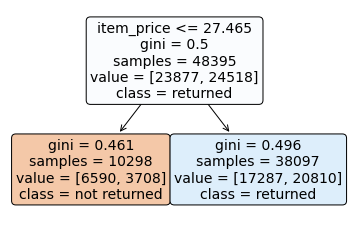

In [56]:
dtc = DecisionTreeClassifier(max_depth= 1, min_samples_split=2)
dtc.fit(X_train, y_train)

y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

print(f"{'Accuracy Train':17} {accuracy_score(y_train, y_pred_train):10.5f}, {'Accuracy Test':17} {accuracy_score(y_test, y_pred_test):10.5f}")
print(f"{'Recall Train':17} {recall_score(y_train, y_pred_train):10.5f}, {'Recall Test':17} {recall_score(y_test, y_pred_test):10.5f}")
print(f"{'Precision Train':17} {precision_score(y_train, y_pred_train):10.5f}, {'Precision Test':17} {precision_score(y_test, y_pred_test):10.5f}")

nodes = plot_tree(dtc, rounded=True, filled=True, fontsize=14, class_names=["not returned", "returned"], feature_names=X_train.columns)

# Baselinemodell mit Crossvalidation durch Kfold (Code aus dem Internet)

In [57]:
crossvalidation = KFold(n_splits= 10, shuffle= True, random_state= 1)
for depth in range (1,10):
 tree_classifier = tree.DecisionTreeClassifier(max_depth = depth, random_state= 1)
 if tree_classifier.fit(X_train, y_train).tree_.max_depth < depth:
  break
 score = np.mean(cross_val_score(tree_classifier, X_train, y_train, scoring= "accuracy", cv= crossvalidation, n_jobs= 1))
 print(depth, score)

1 0.5659668985976544
2 0.5647685514902163
3 0.5719804054180992
4 0.5728067534956167
5 0.5815888169299374
6 0.5829112121041333
7 0.5870852269524985
8 0.5868992509209777
9 0.5864649866187092


# Mit Code aus Ü8 und aus dem Internet: Baseline Modell

In [177]:
min_samples = [2, 10, 20, 50, 100]
kf = KFold(n_splits= 10, shuffle= True, random_state= 1)
best_mean_score = 0
best_combination = dict(max_depth= None, min_samples= 2)

for depth in range(1,19):
 for min_sample in min_samples:
  scores = []
  classifier = DecisionTreeClassifier(max_depth= depth, min_samples_split= min_sample, random_state= 0)
  if classifier.fit(X_train, y_train).tree_.max_depth < depth:
   break
  score = np.mean(cross_val_score(classifier, X_train, y_train, scoring= "accuracy", cv= kf, n_jobs= 1))
  scores.append(score)

  mean_score = np.mean(np.array(scores))
 if mean_score > best_mean_score:
  best_combination["max_depth"] = depth
  best_combination["min_samples"] = min_sample
  best_mean_score = mean_score

In [178]:
print(f"Best Mean_score: {best_mean_score}, Best Max_depth: {best_combination['max_depth']}, Best Min_samples_split: {best_combination['min_samples']}")

Best Mean_score: 0.6252089769930609, Best Max_depth: 6, Best Min_samples_split: 100


In [179]:
best_dtc = DecisionTreeClassifier(max_depth= best_combination["max_depth"], min_samples_split= best_combination["min_samples"], random_state= 0)
best_dtc.fit(X_train, y_train)

y_pred_train_best_dtc = best_dtc.predict(X_train)
y_pred_test_best_dtc = best_dtc.predict(X_test)

print(f"{'Accuracy Train':17} {accuracy_score(y_train, y_pred_train_best_dtc):10.5f}, {'Accuracy Test':17} {accuracy_score(y_test,y_pred_test_best_dtc):10.5f}")
print(f"{'Recall Train':17} {recall_score(y_train, y_pred_train_best_dtc):10.5f}, {'Recall Test':17} {recall_score(y_test,y_pred_test_best_dtc):10.5f}")
print(f"{'Precision Train':17} {precision_score(y_train, y_pred_train_best_dtc):10.5f}, {'Precision Test':17} {precision_score(y_test,y_pred_test_best_dtc):10.5f}")


Accuracy Train       0.63339, Accuracy Test        0.62526
Recall Train         0.67436, Recall Test          0.66372
Precision Train      0.62886, Precision Test       0.62108


# GradientBoostingClassifier

In [14]:
clf = GradientBoostingClassifier(n_estimators= 100, learning_rate= 1, max_depth= 8, random_state= 0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5986445160757088

**Rechenzeit zu lange (bei ca. 80min abgebrochen)**

In [ ]:
gs_crossvalidation = GridSearchCV(
 estimator= GradientBoostingClassifier(),
 param_grid= dict(n_estimators= [100, 500, 1000, 2000], learning_rate= [0.0001, 0.001, 0.01, 0.1], max_depth= [1, 3, 5, 7], subsample= [0.25, 0.5, 0.75, 1], random_state= [0]),
 scoring= "accuracy",
 n_jobs= 1,
 cv= kf
 ).fit(X_train, y_train)
print(f"Best parameters: {gs_crossvalidation.best_params_}, best score: {gs_crossvalidation.best_score_}")

In [180]:
gs_crossvalidation1 = GridSearchCV(
 estimator= HistGradientBoostingClassifier(),
 param_grid= dict(max_iter= [100], learning_rate= [0.001, 0.01, 0.1], max_depth= [1, 3, 5], random_state= [1]),
 scoring= "accuracy",
 n_jobs= 1,
 cv= kf
 ).fit(X_train, y_train)
print(f"Best parameters: {gs_crossvalidation1.best_params_}, best score: {gs_crossvalidation1.best_score_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 100, 'random_state': 1}, best score: 0.6332263299739207


In [181]:
best_gbc = HistGradientBoostingClassifier(max_iter= 100, max_depth= 5, random_state= 1, learning_rate= 0.1).fit(X_train, y_train)
score = np.mean(cross_val_score(best_gbc, X_train, y_train, scoring= "accuracy", cv= kf, n_jobs=1))
score

0.6332263299739207

In [189]:
y_pred_train_best_gbc = best_gbc.predict(X_train)
y_pred_test_best_gbc = best_gbc.predict(X_test)

print(f"{'Accuracy Train':17} {accuracy_score(y_train, y_pred_train_best_gbc):10.5f}, {'Accuracy Test':17} {accuracy_score(y_test,y_pred_test_best_gbc):10.5f}")
print(f"{'Recall Train':17} {recall_score(y_train, y_pred_train_best_gbc):10.5f}, {'Recall Test':17} {recall_score(y_test,y_pred_test_best_gbc):10.5f}")
print(f"{'Precision Train':17} {precision_score(y_train, y_pred_train_best_gbc):10.5f}, {'Precision Test':17} {precision_score(y_test,y_pred_test_best_gbc):10.5f}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- idk
- return1
- return_true

  warnings.warn(message, FutureWarning)


ValueError: X has 217 features, but HistGradientBoostingClassifier is expecting 214 features as input.

# Aufgabe 5 NOCH ANPASSEN !

In [157]:
y_pred_test_best_gbc, y_test

(array([1, 1, 0, ..., 0, 1, 1]),
 48380    1
 54724    0
 19427    1
 22060    1
 20819    0
         ..
 17143    0
 52859    0
 49158    0
 55328    0
 59173    1
 Name: return, Length: 11973, dtype: int64)

In [183]:
X_test["return1"] = y_pred_test_best_gbc
X_test["return_true"] = y_test
X_test["idk"] = X_test.return1 == X_test.return_true
df_aufgabe6 = X_test[X_test.return1 == 1]
df_aufgabe6["sum"] = 0
df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5
df_aufgabe6.loc[df_aufgabe6.idk == False,"sum"] = df_aufgabe6.item_price*(-0.1)*0.5
df_aufgabe6["sum"].sum()

/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_72632/3473076186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aufgabe6["sum"] = 0
/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_72632/3473076186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5


5178.724499999998

In [184]:
def calc_afg6(y_pred_test, y_test):
 X_test["return1"] = y_pred_test
 X_test["return_true"] = y_test
 X_test["idk"] = X_test.return1 == X_test.return_true
 df_aufgabe6 = X_test[X_test.return1 == 1]
 df_aufgabe6["sum"] = 0
 df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5
 df_aufgabe6.loc[df_aufgabe6.idk == False,"sum"] = df_aufgabe6.item_price*(-0.1)*0.5
 return df_aufgabe6["sum"].sum()

In [185]:
calc_afg6(y_pred_test= y_pred_test_best_gbc, y_test= y_test)

/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_72632/166447438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aufgabe6["sum"] = 0
/var/folders/f6/gs3z1yx9005b5dmpnd_z3t3m0000gn/T/ipykernel_72632/166447438.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5


5178.724499999998

# BaggingClassifier

[[3579 2403]
 [2092 4025]]


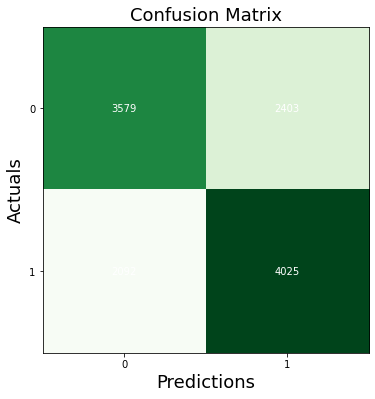

In [190]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

cm_hgb = confusion_matrix(y_test, y_pred_test_best_gbc)
print(cm_hgb)
fig, ax = plot_confusion_matrix(conf_mat=cm_hgb, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [193]:
pd.crosstab(y_test, y_pred_test_best_gbc, rownames= ["True"], colnames= ["Predicted"], margins= True)

Predicted,0,1,All
True,,,
0,3579,2403,5982
1,2092,4025,6117
All,5671,6428,12099
